### **0. Setup**

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet']

# Make a folder if it not there yet and if needed
# !mkdir ../jupyter_figures

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/Sun2 intensity in nucleus/siCDS,siPIS/'

### **1. Concanatate all the CSV files**

In [2]:
df = pd.DataFrame()

for path, subdirs, files in os.walk(directory):
    for file in files:
        if file.endswith('csv'):
            _df = pd.read_csv(os.path.join(path, file))
            df = pd.concat([df, _df], axis=0)

In [3]:
df.head()

,,Area,Mean,Circ.,AR,Round,Solidity,DAPI mean,File name
0,1,225.773,3425.083,0.827,2.019,0.495,1.001,7442.291,3-29-22 U2OSKO siPIS 488LmnAC 561Sun2 t2-001.nd2
1,2,27.875,5151.773,0.892,1.619,0.618,1.002,17950.240,3-29-22 U2OSKO siPIS 488LmnAC 561Sun2 t2-001.nd2
2,3,97.354,2831.199,0.827,1.959,0.510,0.997,6225.849,3-29-22 U2OSKO siPIS 488LmnAC 561Sun2 t2-001.nd2
3,4,137.988,3007.911,0.858,1.235,0.810,0.979,6380.111,3-29-22 U2OSKO siPIS 488LmnAC 561Sun2 t2-001.nd2
4,5,216.343,3116.814,0.825,2.038,0.491,0.998,7252.453,3-29-22 U2OSKO siPIS 488LmnAC 561Sun2 t2-001.nd2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 16
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0              888 non-null    int64  
 1   Area       888 non-null    float64
 2   Mean       888 non-null    float64
 3   Circ.      888 non-null    float64
 4   AR         888 non-null    float64
 5   Round      888 non-null    float64
 6   Solidity   888 non-null    float64
 7   DAPI mean  888 non-null    float64
 8   File name  888 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 69.4+ KB


#### Check the number of files

In [4]:
files = df['File name'].unique()
print(len(files))

56


### **2. Add columns**

####  **Cell_type**

In [5]:
df.loc[df['File name'].str.contains('ctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('KO'), 'Cell type'] = 'CTDNEP1 KO'

#### **siRNA type**

In [6]:
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = 'siCtrl'
df.loc[df['File name'].str.contains('siCDS1'), 'siRNA type'] = 'siCDS1'
df.loc[df['File name'].str.contains('siCDS2'), 'siRNA type'] = 'siCDS2'
df.loc[df['File name'].str.contains('siPIS'), 'siRNA type'] = 'siPIS'

#### **Plasmid type**

In [7]:
df.loc[df['File name'].str.contains('WT'), 'Plasmid type'] = 'WT'
df.loc[df['File name'].str.contains('DE'), 'Plasmid type'] = 'DE'

#### **Image number**

In [7]:
df['Image number'] = df['File name'].str[-7:-4]

##### Check the number is correctly extracted

In [8]:
print(list(df['Image number'].unique())[1])

002


#### **Tag expression**

##### **Check Tag intensity**

(1000.0, 4000.0)

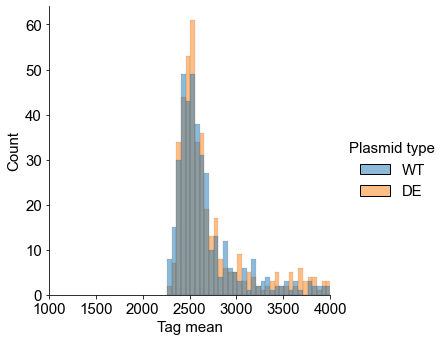

In [11]:
hist = sns.displot(data=df, x='Tag mean', hue='Plasmid type', hue_order=['WT', 'DE'], binwidth=50)
plt.xlim([1000,4000])

##### **Determine expression (+) or (-) by a threshold**

In [11]:
# Set the threshold
min_tag_intensity = 3200

# Sort Tag mean based on the threshold
df['Tag expression'] = df.apply(lambda x: '(+)' if x['Tag mean'] > min_tag_intensity else '(-)', axis=1)

#### **C3 channel intensity (background subtracted)**

##### **C3 distribution**

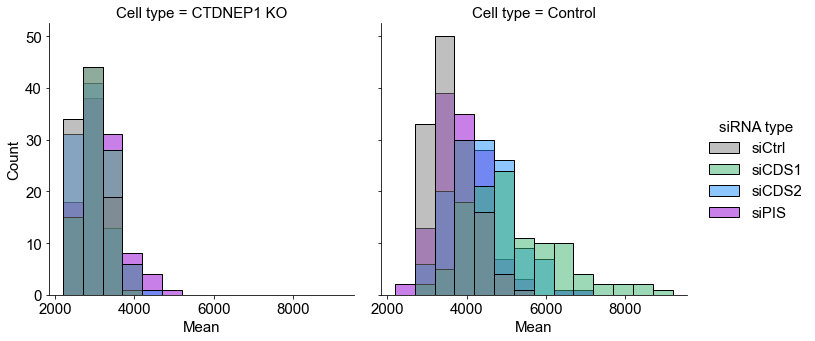

In [12]:
# hist = sns.displot(x='Mean', data=df, hue='Tag expression', binwidth=500)
hist = sns.displot(x='Mean', data=df, col='Cell type', hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal, binwidth=500)

In [13]:
# df.groupby('Tag expression')['Mean'].min()
df.groupby(['Cell type', 'siRNA type'])['Mean'].min()

Cell type   siRNA type
CTDNEP1 KO  siCDS1        2288.219
            siCDS2        2310.029
            siCtrl        2195.403
            siPIS         2343.428
Control     siCDS1        2983.488
            siCDS2        2818.070
            siCtrl        2720.038
            siPIS         2401.668
Name: Mean, dtype: float64

##### **Background subtraction from C3 intensity value**

In [14]:
background_C3 = 2000

df['C3 mean - background'] = df['Mean'] - background_C3

#### **Normalized C3 channel intensity (background subtracted)**

In [16]:
# set the baseline, which is either siCtrl for control cells or plasmid (-) cells
# C3_mean_baseline = np.mean(df[df['Tag expression']=='(-)']['C3 mean - background'])
C3_mean_baseline = np.mean(df[(df['Cell type'] == 'Control') & (df['siRNA type'] == 'siCtrl')]['C3 mean - background'])

# then normalize
df['C3-Back_normalized'] = df['C3 mean - background'] / C3_mean_baseline

#### **ROI number**

In [17]:
df = df.rename(columns={' ': 'ROI number'})

#### **Sample type (for Tukey test)**

In [18]:
# specify what columns are joined to name 'Sample_type'

# sampletype_columns = ['Cell type', 'Plasmid type', 'Tag expression']
sampletype_columns = ['Cell type', 'siRNA type']

df['Sample_type'] = df[sampletype_columns].agg('_'.join, axis=1)

### **3. Exclude mitotic cells and nuclei with small area**

#### **3-1. Mitotic cells**

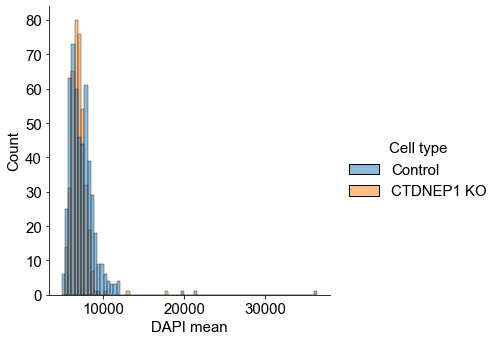

In [19]:
hist = sns.displot(data=df, x='DAPI mean', hue='Cell type', hue_order=['Control', 'CTDNEP1 KO'], binwidth=400)
# plt.xlim([1000,4000])

#### **Remove cells with too hight DAPI intensity, which are likely mitotic cells**

In [20]:
max_DNA_intensity = 15000

df = df[df['DAPI mean'] < max_DNA_intensity]

#### **3-2. Nuclei with small area**

In [22]:
min_area_of_roi = 60
# max_area_of_roi = 200
df = df[(df['Area'] > min_area_of_roi)]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROI number            765 non-null    int64  
 1   Area                  765 non-null    float64
 2   Mean                  765 non-null    float64
 3   Circ.                 765 non-null    float64
 4   AR                    765 non-null    float64
 5   Round                 765 non-null    float64
 6   Solidity              765 non-null    float64
 7   DAPI mean             765 non-null    float64
 8   File name             765 non-null    object 
 9   Cell type             765 non-null    object 
 10  siRNA type            765 non-null    object 
 11  Image number          765 non-null    object 
 12  C3 mean - background  765 non-null    float64
 13  C3-Back_normalized    765 non-null    float64
 14  Sample_type           765 non-null    object 
dtypes: float64(9), int64(1),

### **4. Inspect the data**

#### **4-1. Check cell counts per sample**

Text(0.5, 1.0, 'Number of cells')

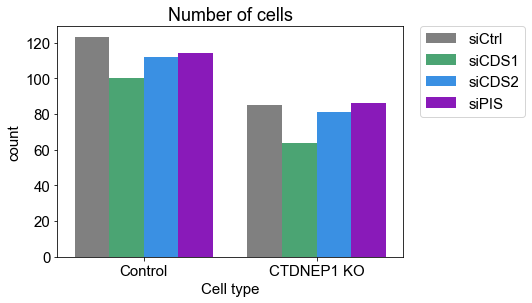

In [30]:
fig = plt.figure()
ax_count = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax_count = sns.countplot(data=df, x='Sample_type')
# ax_count = sns.countplot(data=df, x='Plasmid type', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
ax_count = sns.countplot(data=df, x='Cell type', order=['Control', 'CTDNEP1 KO'], 
                         hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Number of cells')
# ax_count.set_xticklabels(labels=samples_order, rotation=45, ha='right')

In [31]:
# df.groupby(['Plasmid type', 'Tag expression']).size()
df.groupby(['Cell type', 'siRNA type']).size()

Cell type   siRNA type
CTDNEP1 KO  siCDS1         64
            siCDS2         81
            siCtrl         85
            siPIS          86
Control     siCDS1        100
            siCDS2        112
            siCtrl        123
            siPIS         114
dtype: int64

#### **4-3. C3 channel normalized intensity**

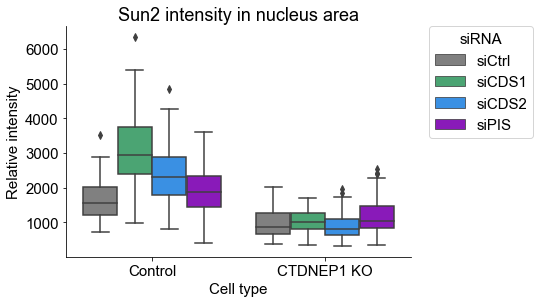

In [29]:
fig = plt.figure(figsize=(6,4))
ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# For rescue experiments:
# ax_box = sns.boxplot(data=df, x='Plasmid type', y='C3-Back_normalized', order=['WT', 'DE'], hue='Tag expression', hue_order=['(-)', '(+)'], palette=my_pal)
# plt.legend(title='Flag expression', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# For siRNA experiments:
ax_box = sns.boxplot(data=df, x='Cell type', y='C3 mean - background', order=['Control', 'CTDNEP1 KO'], 
                     hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal)
plt.legend(title='siRNA', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Used in common:
plt.title('Sun2 intensity in nucleus area')
plt.ylabel('Relative intensity')
ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)

In [32]:
fig.savefig(directory + '/P-196_C3_intensity.pdf', bbox_inches='tight', transparent=True)

#### **Scatter plot (Tag vs C3)**

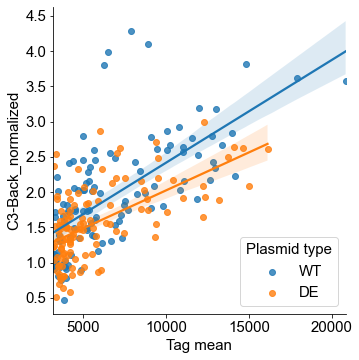

In [32]:
scatter = sns.lmplot(x='Tag mean', y='C3-Back_normalized', data=df[df['Tag expression']=='(+)'], hue='Plasmid type', hue_order=['WT', 'DE'], legend_out=False)

In [33]:
scatter.savefig(directory + '/Tag_vs_C3.jpg', bbox_inches='tight')

#### **4-4. Tukey test**

In [33]:
res = pairwise_tukeyhsd(df['C3-Back_normalized'], df['Sample_type'], alpha=0.05)

In [34]:
print(res)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
CTDNEP1 KO_siCDS1 CTDNEP1 KO_siCDS2  -0.0678    0.9 -0.2676   0.132  False
CTDNEP1 KO_siCDS1 CTDNEP1 KO_siCtrl  -0.0465    0.9 -0.2442  0.1513  False
CTDNEP1 KO_siCDS1  CTDNEP1 KO_siPIS   0.0839    0.9 -0.1134  0.2811  False
CTDNEP1 KO_siCDS1    Control_siCDS1   1.2579  0.001  1.0666  1.4492   True
CTDNEP1 KO_siCDS1    Control_siCDS2   0.8275  0.001  0.6403  1.0147   True
CTDNEP1 KO_siCDS1    Control_siCtrl   0.3647  0.001  0.1806  0.5489   True
CTDNEP1 KO_siCDS1     Control_siPIS   0.5323  0.001  0.3457   0.719   True
CTDNEP1 KO_siCDS2 CTDNEP1 KO_siCtrl   0.0213    0.9 -0.1642  0.2068  False
CTDNEP1 KO_siCDS2  CTDNEP1 KO_siPIS   0.1517 0.2002 -0.0333  0.3367  False
CTDNEP1 KO_siCDS2    Control_siCDS1   1.3257  0.001  1.1471  1.5043   True
CTDNEP1 KO_siCDS2    Cont